In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "fsv4"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 287
Categorical features: 6
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 359
Categorical Columns: 6


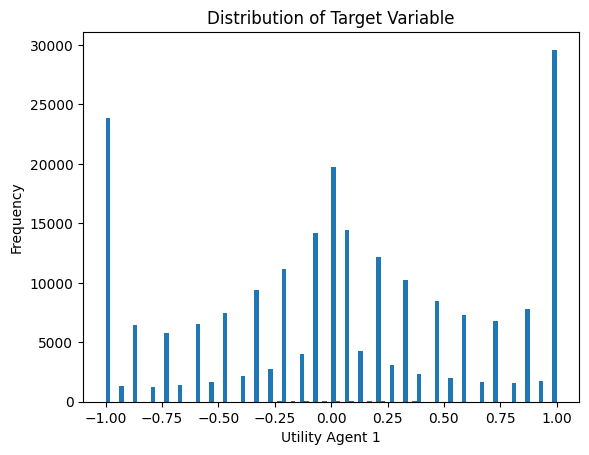

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55315


[100]	val-rmse:0.46490


[200]	val-rmse:0.44505


[300]	val-rmse:0.43727


[400]	val-rmse:0.43231


[500]	val-rmse:0.42914


[600]	val-rmse:0.42703


[700]	val-rmse:0.42599


[800]	val-rmse:0.42497


[900]	val-rmse:0.42421


[1000]	val-rmse:0.42368


[1100]	val-rmse:0.42316


[1200]	val-rmse:0.42283


[1300]	val-rmse:0.42249


[1400]	val-rmse:0.42231


[1500]	val-rmse:0.42221


[1600]	val-rmse:0.42223


[1700]	val-rmse:0.42217


[1800]	val-rmse:0.42201


[1900]	val-rmse:0.42195


[2000]	val-rmse:0.42189


[2100]	val-rmse:0.42186


[2200]	val-rmse:0.42189


[2300]	val-rmse:0.42187


[2400]	val-rmse:0.42178


[2499]	val-rmse:0.42183


Fold 1 - RMSE: 0.4214756384874573
Fold 2


[0]	val-rmse:0.58856


[100]	val-rmse:0.47954


[200]	val-rmse:0.46201


[300]	val-rmse:0.45425


[400]	val-rmse:0.45037


[500]	val-rmse:0.44800


[600]	val-rmse:0.44625


[700]	val-rmse:0.44487


[800]	val-rmse:0.44385


[900]	val-rmse:0.44328


[1000]	val-rmse:0.44290


[1100]	val-rmse:0.44258


[1200]	val-rmse:0.44223


[1300]	val-rmse:0.44196


[1400]	val-rmse:0.44174


[1500]	val-rmse:0.44155


[1600]	val-rmse:0.44131


[1700]	val-rmse:0.44121


[1800]	val-rmse:0.44116


[1900]	val-rmse:0.44116


[2000]	val-rmse:0.44105


[2100]	val-rmse:0.44108


[2200]	val-rmse:0.44108


[2300]	val-rmse:0.44108


[2400]	val-rmse:0.44106


[2499]	val-rmse:0.44102


Fold 2 - RMSE: 0.4407097093054989
Fold 3


[0]	val-rmse:0.60608


[100]	val-rmse:0.47112


[200]	val-rmse:0.44812


[300]	val-rmse:0.44031


[400]	val-rmse:0.43568


[500]	val-rmse:0.43365


[600]	val-rmse:0.43196


[700]	val-rmse:0.43070


[800]	val-rmse:0.42993


[900]	val-rmse:0.42921


[1000]	val-rmse:0.42869


[1100]	val-rmse:0.42847


[1200]	val-rmse:0.42793


[1300]	val-rmse:0.42789


[1400]	val-rmse:0.42771


[1500]	val-rmse:0.42757


[1600]	val-rmse:0.42736


[1700]	val-rmse:0.42722


[1800]	val-rmse:0.42711


[1900]	val-rmse:0.42706


[2000]	val-rmse:0.42693


[2100]	val-rmse:0.42694


[2200]	val-rmse:0.42684


[2300]	val-rmse:0.42672


[2400]	val-rmse:0.42669


[2499]	val-rmse:0.42665


Fold 3 - RMSE: 0.4261959427669129
Fold 4


[0]	val-rmse:0.59663


[100]	val-rmse:0.48111


[200]	val-rmse:0.45804


[300]	val-rmse:0.44843


[400]	val-rmse:0.44407


[500]	val-rmse:0.44094


[600]	val-rmse:0.43890


[700]	val-rmse:0.43748


[800]	val-rmse:0.43648


[900]	val-rmse:0.43574


[1000]	val-rmse:0.43518


[1100]	val-rmse:0.43467


[1200]	val-rmse:0.43436


[1300]	val-rmse:0.43396


[1400]	val-rmse:0.43367


[1500]	val-rmse:0.43345


[1600]	val-rmse:0.43312


[1700]	val-rmse:0.43293


[1800]	val-rmse:0.43278


[1900]	val-rmse:0.43258


[2000]	val-rmse:0.43250


[2100]	val-rmse:0.43244


[2200]	val-rmse:0.43233


[2300]	val-rmse:0.43226


[2400]	val-rmse:0.43219


[2499]	val-rmse:0.43210


Fold 4 - RMSE: 0.43170644157908716
Fold 5


[0]	val-rmse:0.54709


[100]	val-rmse:0.45545


[200]	val-rmse:0.43189


[300]	val-rmse:0.42225


[400]	val-rmse:0.41646


[500]	val-rmse:0.41309


[600]	val-rmse:0.41092


[700]	val-rmse:0.40931


[800]	val-rmse:0.40813


[900]	val-rmse:0.40752


[1000]	val-rmse:0.40688


[1100]	val-rmse:0.40615


[1200]	val-rmse:0.40573


[1300]	val-rmse:0.40540


[1400]	val-rmse:0.40510


[1500]	val-rmse:0.40501


[1600]	val-rmse:0.40482


[1700]	val-rmse:0.40478


[1800]	val-rmse:0.40468


[1900]	val-rmse:0.40464


[2000]	val-rmse:0.40445


[2100]	val-rmse:0.40450


[2200]	val-rmse:0.40458


[2300]	val-rmse:0.40467


[2400]	val-rmse:0.40461


[2499]	val-rmse:0.40471


Fold 5 - RMSE: 0.40429024029711436
List of oof scores: [0.4214756384874573, 0.4407097093054989, 0.4261959427669129, 0.43170644157908716, 0.40429024029711436]
Average oof score: 0.4248755944872141


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53431


[100]	val-rmse:0.44766


[200]	val-rmse:0.42830


[300]	val-rmse:0.42069


[400]	val-rmse:0.41666


[500]	val-rmse:0.41383


[600]	val-rmse:0.41220


[700]	val-rmse:0.41085


[800]	val-rmse:0.40966


[900]	val-rmse:0.40898


[1000]	val-rmse:0.40838


[1100]	val-rmse:0.40760


[1200]	val-rmse:0.40720


[1300]	val-rmse:0.40679


[1400]	val-rmse:0.40659


[1500]	val-rmse:0.40639


[1600]	val-rmse:0.40632


[1700]	val-rmse:0.40616


[1800]	val-rmse:0.40601


[1900]	val-rmse:0.40586


[2000]	val-rmse:0.40572


[2100]	val-rmse:0.40544


[2200]	val-rmse:0.40530


[2300]	val-rmse:0.40525


[2400]	val-rmse:0.40528


[2499]	val-rmse:0.40525


Fold 1 - RMSE: 0.40488728824648307
Fold 2


[0]	val-rmse:0.54672


[100]	val-rmse:0.43376


[200]	val-rmse:0.41458


[300]	val-rmse:0.40852


[400]	val-rmse:0.40539


[500]	val-rmse:0.40361


[600]	val-rmse:0.40267


[700]	val-rmse:0.40215


[800]	val-rmse:0.40162


[900]	val-rmse:0.40132


[1000]	val-rmse:0.40116


[1100]	val-rmse:0.40115


[1200]	val-rmse:0.40106


[1300]	val-rmse:0.40101


[1400]	val-rmse:0.40098


[1500]	val-rmse:0.40106


[1600]	val-rmse:0.40104


[1700]	val-rmse:0.40114


[1800]	val-rmse:0.40118


[1900]	val-rmse:0.40122


[2000]	val-rmse:0.40122


[2100]	val-rmse:0.40132


[2200]	val-rmse:0.40139


[2300]	val-rmse:0.40144


[2400]	val-rmse:0.40153


[2499]	val-rmse:0.40157


Fold 2 - RMSE: 0.40104260574253037
Fold 3


[0]	val-rmse:0.61323


[100]	val-rmse:0.49192


[200]	val-rmse:0.46610


[300]	val-rmse:0.45495


[400]	val-rmse:0.44869


[500]	val-rmse:0.44497


[600]	val-rmse:0.44295


[700]	val-rmse:0.44134


[800]	val-rmse:0.43984


[900]	val-rmse:0.43873


[1000]	val-rmse:0.43805


[1100]	val-rmse:0.43756


[1200]	val-rmse:0.43714


[1300]	val-rmse:0.43673


[1400]	val-rmse:0.43625


[1500]	val-rmse:0.43575


[1600]	val-rmse:0.43552


[1700]	val-rmse:0.43539


[1800]	val-rmse:0.43514


[1900]	val-rmse:0.43501


[2000]	val-rmse:0.43479


[2100]	val-rmse:0.43473


[2200]	val-rmse:0.43461


[2300]	val-rmse:0.43450


[2400]	val-rmse:0.43440


[2499]	val-rmse:0.43420


Fold 3 - RMSE: 0.43374651121589364
Fold 4


[0]	val-rmse:0.60614


[100]	val-rmse:0.49300


[200]	val-rmse:0.47090


[300]	val-rmse:0.46054


[400]	val-rmse:0.45469


[500]	val-rmse:0.45176


[600]	val-rmse:0.44980


[700]	val-rmse:0.44839


[800]	val-rmse:0.44725


[900]	val-rmse:0.44654


[1000]	val-rmse:0.44578


[1100]	val-rmse:0.44514


[1200]	val-rmse:0.44496


[1300]	val-rmse:0.44484


[1400]	val-rmse:0.44450


[1500]	val-rmse:0.44444


[1600]	val-rmse:0.44420


[1700]	val-rmse:0.44403


[1800]	val-rmse:0.44385


[1900]	val-rmse:0.44380


[2000]	val-rmse:0.44364


[2100]	val-rmse:0.44366


[2200]	val-rmse:0.44368


[2300]	val-rmse:0.44369


[2400]	val-rmse:0.44375


[2499]	val-rmse:0.44378


Fold 4 - RMSE: 0.44334743261745047
Fold 5


[0]	val-rmse:0.59072


[100]	val-rmse:0.48544


[200]	val-rmse:0.46083


[300]	val-rmse:0.45003


[400]	val-rmse:0.44428


[500]	val-rmse:0.44111


[600]	val-rmse:0.43924


[700]	val-rmse:0.43742


[800]	val-rmse:0.43611


[900]	val-rmse:0.43530


[1000]	val-rmse:0.43474


[1100]	val-rmse:0.43412


[1200]	val-rmse:0.43365


[1300]	val-rmse:0.43313


[1400]	val-rmse:0.43294


[1500]	val-rmse:0.43276


[1600]	val-rmse:0.43264


[1700]	val-rmse:0.43257


[1800]	val-rmse:0.43248


[1900]	val-rmse:0.43233


[2000]	val-rmse:0.43228


[2100]	val-rmse:0.43202


[2200]	val-rmse:0.43207


[2300]	val-rmse:0.43204


[2400]	val-rmse:0.43194


[2499]	val-rmse:0.43191


Fold 5 - RMSE: 0.43137760847513157
List of oof scores: [0.40488728824648307, 0.40104260574253037, 0.43374651121589364, 0.44334743261745047, 0.43137760847513157]
Average oof score: 0.42288028925949783


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57534


[100]	val-rmse:0.47982


[200]	val-rmse:0.45892


[300]	val-rmse:0.45185


[400]	val-rmse:0.44752


[500]	val-rmse:0.44499


[600]	val-rmse:0.44340


[700]	val-rmse:0.44240


[800]	val-rmse:0.44129


[900]	val-rmse:0.44073


[1000]	val-rmse:0.44048


[1100]	val-rmse:0.44003


[1200]	val-rmse:0.43981


[1300]	val-rmse:0.43970


[1400]	val-rmse:0.43963


[1500]	val-rmse:0.43960


[1600]	val-rmse:0.43944


[1700]	val-rmse:0.43925


[1800]	val-rmse:0.43916


[1900]	val-rmse:0.43908


[2000]	val-rmse:0.43900


[2100]	val-rmse:0.43906


[2200]	val-rmse:0.43910


[2300]	val-rmse:0.43915


[2400]	val-rmse:0.43923


[2499]	val-rmse:0.43931


Fold 1 - RMSE: 0.4388662685286276
Fold 2


[0]	val-rmse:0.57411


[100]	val-rmse:0.47111


[200]	val-rmse:0.44706


[300]	val-rmse:0.43768


[400]	val-rmse:0.43138


[500]	val-rmse:0.42787


[600]	val-rmse:0.42557


[700]	val-rmse:0.42359


[800]	val-rmse:0.42222


[900]	val-rmse:0.42113


[1000]	val-rmse:0.42044


[1100]	val-rmse:0.41978


[1200]	val-rmse:0.41917


[1300]	val-rmse:0.41888


[1400]	val-rmse:0.41854


[1500]	val-rmse:0.41835


[1600]	val-rmse:0.41823


[1700]	val-rmse:0.41796


[1800]	val-rmse:0.41793


[1900]	val-rmse:0.41794


[2000]	val-rmse:0.41772


[2100]	val-rmse:0.41763


[2200]	val-rmse:0.41758


[2300]	val-rmse:0.41749


[2400]	val-rmse:0.41754


[2499]	val-rmse:0.41760


Fold 2 - RMSE: 0.4172891878255326
Fold 3


[0]	val-rmse:0.57681


[100]	val-rmse:0.47208


[200]	val-rmse:0.45214


[300]	val-rmse:0.44415


[400]	val-rmse:0.43989


[500]	val-rmse:0.43729


[600]	val-rmse:0.43570


[700]	val-rmse:0.43472


[800]	val-rmse:0.43399


[900]	val-rmse:0.43325


[1000]	val-rmse:0.43285


[1100]	val-rmse:0.43239


[1200]	val-rmse:0.43208


[1300]	val-rmse:0.43189


[1400]	val-rmse:0.43180


[1500]	val-rmse:0.43183


[1600]	val-rmse:0.43174


[1700]	val-rmse:0.43175


[1800]	val-rmse:0.43164


[1900]	val-rmse:0.43161


[2000]	val-rmse:0.43151


[2100]	val-rmse:0.43139


[2200]	val-rmse:0.43139


[2300]	val-rmse:0.43135


[2400]	val-rmse:0.43139


[2499]	val-rmse:0.43143


Fold 3 - RMSE: 0.43106673988247496
Fold 4


[0]	val-rmse:0.57649


[100]	val-rmse:0.46332


[200]	val-rmse:0.44125


[300]	val-rmse:0.43362


[400]	val-rmse:0.42958


[500]	val-rmse:0.42712


[600]	val-rmse:0.42582


[700]	val-rmse:0.42443


[800]	val-rmse:0.42384


[900]	val-rmse:0.42317


[1000]	val-rmse:0.42268


[1100]	val-rmse:0.42242


[1200]	val-rmse:0.42193


[1300]	val-rmse:0.42162


[1400]	val-rmse:0.42136


[1500]	val-rmse:0.42119


[1600]	val-rmse:0.42104


[1700]	val-rmse:0.42092


[1800]	val-rmse:0.42076


[1900]	val-rmse:0.42071


[2000]	val-rmse:0.42076


[2100]	val-rmse:0.42086


[2200]	val-rmse:0.42081


[2300]	val-rmse:0.42072


[2400]	val-rmse:0.42072


[2499]	val-rmse:0.42072


Fold 4 - RMSE: 0.4203703859564748
Fold 5


[0]	val-rmse:0.58566


[100]	val-rmse:0.48127


[200]	val-rmse:0.45889


[300]	val-rmse:0.44883


[400]	val-rmse:0.44274


[500]	val-rmse:0.43913


[600]	val-rmse:0.43703


[700]	val-rmse:0.43504


[800]	val-rmse:0.43390


[900]	val-rmse:0.43305


[1000]	val-rmse:0.43245


[1100]	val-rmse:0.43182


[1200]	val-rmse:0.43128


[1300]	val-rmse:0.43088


[1400]	val-rmse:0.43039


[1500]	val-rmse:0.43022


[1600]	val-rmse:0.43002


[1700]	val-rmse:0.42987


[1800]	val-rmse:0.42967


[1900]	val-rmse:0.42947


[2000]	val-rmse:0.42944


[2100]	val-rmse:0.42930


[2200]	val-rmse:0.42937


[2300]	val-rmse:0.42925


[2400]	val-rmse:0.42913


[2499]	val-rmse:0.42903


Fold 5 - RMSE: 0.4286246025700446
List of oof scores: [0.4388662685286276, 0.4172891878255326, 0.43106673988247496, 0.4203703859564748, 0.4286246025700446]
Average oof score: 0.42724343695263095


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4215
Score: 0.4407
Score: 0.4262
Score: 0.4317
Score: 0.4043
Average CV1 Score: 0.4249

CV2 OOF Scores:
Score: 0.4049
Score: 0.4010
Score: 0.4337
Score: 0.4433
Score: 0.4314
Average CV2 Score: 0.4229

CV3 OOF Scores:
Score: 0.4389
Score: 0.4173
Score: 0.4311
Score: 0.4204
Score: 0.4286
Average CV3 Score: 0.4272


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

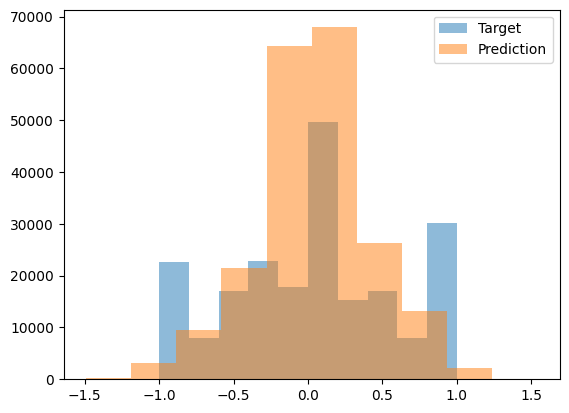

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***